## Creating Data

In [1]:
import pyLabFEM as FE
from pyLabMaterial import Material
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

Yield loci of anisotropic reference material and isotropic material


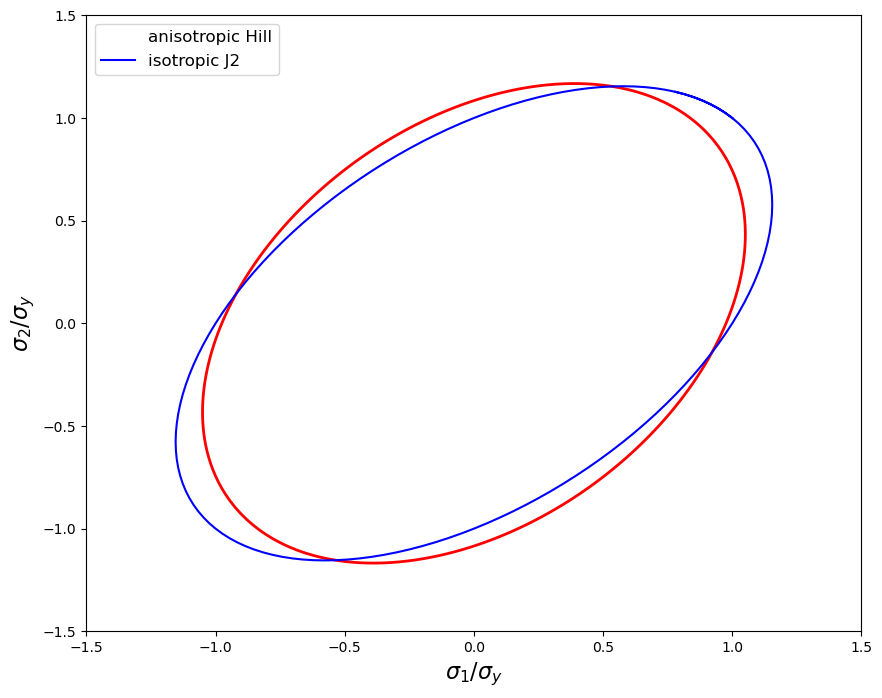

In [2]:
'define two elastic-plastic materials with identical yield strength and elastic properties'
E=200.e3
nu=0.3
sy = 150.
'anistropic Hill-material as reference'
mat_h = Material(name='anisotropic Hill')
mat_h.elasticity(E=E, nu=nu)
mat_h.plasticity(sy=sy, hill=[0.7,1.,1.4], drucker=0., khard=0.)
'isotropic material for ML flow rule'
mat_ml = Material(name='ML flow rule')
mat_ml.elasticity(E=E, nu=nu)
mat_ml.plasticity(sy=sy, hill=[1.,1.,1.], drucker=0., khard=0.)
print('Yield loci of anisotropic reference material and isotropic material')
ax = mat_h.plot_yield_locus(xstart=-1.5, xend=1.5, iso=True)

In [3]:
'Create training data in deviatoric stress space for components seq and theta'
def create_data(N, mat, extend=False, rand=False):
    # create stresses along unit circle normal to hydrostatic axis
    if not rand:
        theta = np.linspace(-np.pi, np.pi, N)
    else:
        theta = 2.*(np.random.rand(N)-0.5)*np.pi
    sig = FE.sp_cart(np.array([np.ones(N)*np.sqrt(3/2), theta]).T)
    offs = 0.01
    x = offs*sig
    N = 23
    for i in range(N):
        hh = offs + (1.4-offs)*(i+1)/N
        x = np.append(x, hh*sig, axis=0)
    if extend:
        # add training points in plastic regime to avoid fallback of SVC decision fct. to zero
        x = np.append(x, 2.*sig, axis=0)
        x = np.append(x, 3.*sig, axis=0)
        x = np.append(x, 4.*sig, axis=0) 
        x = np.append(x, 5.*sig, axis=0)
    'result data for ML yield function (only sign is considered)'
    y = np.sign(mat.calc_yf(x*mat.sy, ana=True))
    return x,y 


In [4]:
'Training and testing data for ML yield function, based on reference Material mat_h'
ndata = 36
ntest = np.maximum(20, int(ndata/10))
x_train, y_train = create_data(ndata, mat_h, extend=True) 
x_test, y_test = create_data(ntest, mat_h, rand=True)
x_train *= mat_h.sy
x_test *= mat_h.sy

## Visualizing Data

In [5]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(1008, 3) (1008,)
(480, 3) (480,)


In [6]:
import pandas as pd

In [7]:
data = {'sigma_1':x_train[:,0], 'sigma_2':x_train[:,1], 'sigma_3':x_train[:,2]}

In [8]:
df = pd.DataFrame(data)
pd.set_option('display.max_columns', 3)
pd.set_option('display.max_rows', 1008)
df

,sigma_1,sigma_2,sigma_3
0,-1.224745,0.612372,0.612372
1,-1.205063,0.413143,0.791920
2,-1.146649,0.200635,0.946014
3,-1.051381,-0.018321,1.069702
4,-0.922320,-0.236689,1.159010
5,-0.763616,-0.447450,1.211065
6,-0.580368,-0.643829,1.224197
7,-0.378467,-0.819514,1.197981
8,-0.164402,-0.968860,1.133262
9,0.054948,-1.087066,1.032118


In [9]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Logistic regression

In [10]:
from sklearn.linear_model import LogisticRegression

In [11]:
log_reg = LogisticRegression()


### Logistic Regression with fewer features

In [12]:
log_reg.fit(x_train, y_train)

LogisticRegression()

In [13]:
y_pred3 = log_reg.predict(x_test)

In [14]:
print(classification_report(y_test, y_pred3))

              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00       279
         1.0       0.40      0.92      0.56       201

    accuracy                           0.39       480
   macro avg       0.20      0.46      0.28       480
weighted avg       0.17      0.39      0.23       480



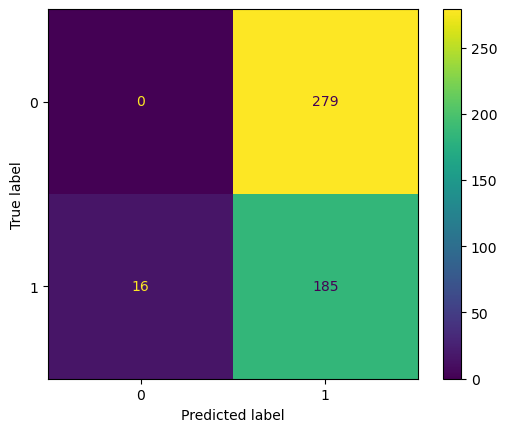

In [15]:
cm = confusion_matrix(y_test, y_pred3)
disp3 = ConfusionMatrixDisplay(cm)
disp3.plot()
plt.show()

### Converting stress to cylinderical coordinate

In [16]:
def S_vm (x):
    S_vmises = np.sqrt(3*FE.seq_J2(x))
    return S_vmises

svm_train = S_vm(x_train)
svm_test = S_vm(x_test)

x_train1 = np.append(x_train, svm_train.reshape(1008, 1), axis = 1)
x_test1 = np.append(x_test, svm_test.reshape(480, 1), axis=1)

In [17]:
sj2_train = FE.seq_J2(x_train)/mat_h.sy - 1
sj2_test = FE.seq_J2(x_test)/mat_h.sy -1

x_train2 = np.append(x_train1, sj2_train.reshape(1008, 1), axis = 1)
x_test2 = np.append(x_test1, sj2_test.reshape(480, 1), axis=1)

In [18]:
theta_train =FE.polar_ang(x_train)/np.pi
theta_test = FE.polar_ang(x_test)/np.pi

x_train3= np.append(x_train2, theta_train.reshape(1008, 1), axis =1)
x_test3 = np.append(x_test2, theta_test.reshape(480, 1), axis =1)

In [19]:
x_train_cyl = np.zeros((len(sj2_train),2))
x_test_cyl = np.zeros((len(sj2_test),2))
x_train_cyl[:,0] = sj2_train
x_train_cyl[:,1] = theta_train

x_test_cyl[:,0] = sj2_test
x_test_cyl[:,1] = theta_test

In [20]:
x_train_cyl[:5,:]

array([[-0.98775255, -1.        ],
       [-0.98775255, -0.94285714],
       [-0.98775255, -0.88571429],
       [-0.98775255, -0.82857143],
       [-0.98775255, -0.77142857]])

In [21]:
x_test_cyl[:5,:]

array([[-0.98775255, -0.01556551],
       [-0.98775255,  0.56679431],
       [-0.98775255, -0.87955065],
       [-0.98775255, -0.55080964],
       [-0.98775255, -0.70789732]])

In [22]:
log_reg_cyl = LogisticRegression()

In [23]:
log_reg_cyl.fit(x_train_cyl, y_train)

LogisticRegression()

In [24]:
y_pred5 = log_reg_cyl.predict(x_test_cyl)

In [25]:
print(classification_report(y_test, y_pred5))

              precision    recall  f1-score   support

        -1.0       0.99      0.97      0.98       279
         1.0       0.97      0.99      0.98       201

    accuracy                           0.98       480
   macro avg       0.98      0.98      0.98       480
weighted avg       0.98      0.98      0.98       480



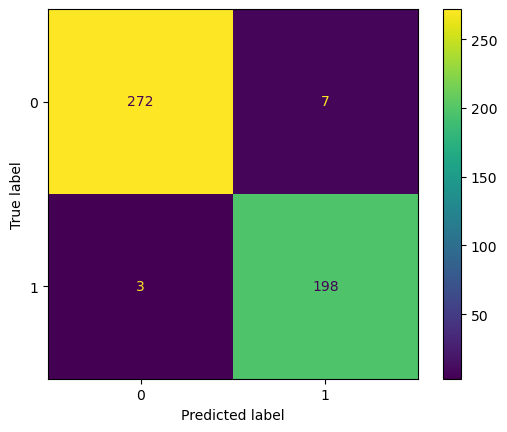

In [26]:
cm = confusion_matrix(y_test, y_pred5)
disp5 = ConfusionMatrixDisplay(cm)
disp5.plot()
plt.show()

In [27]:
from sklearn.inspection import DecisionBoundaryDisplay

/Users/zaheennasir/anaconda3/envs/sciml/lib/python3.11/site-packages/sklearn/inspection/_plot/decision_boundary.py:186: UserWarning: The following kwargs were not used by contour: 'x_label', 'y_label'
  self.surface_ = plot_func(self.xx0, self.xx1, self.response, **kwargs)


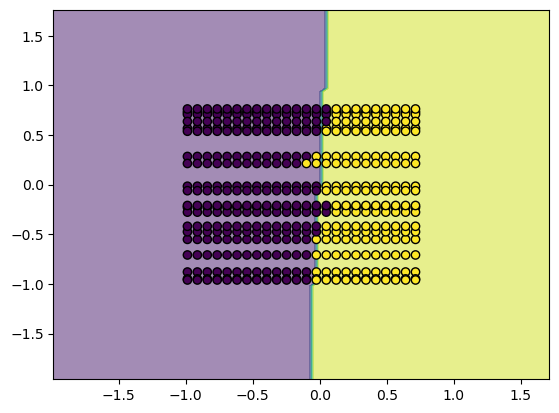

In [28]:
disp8 = DecisionBoundaryDisplay.from_estimator(log_reg_cyl,
                                                x_test_cyl,
                                                response_method = "predict",
                                                x_label = "Equivalent Stress",
                                                y_label = "Theta",
                                                alpha = 0.5)
disp8.ax_.scatter(x_test_cyl[:,0], x_test_cyl[:,1], c=y_test, edgecolor="k")
plt.show()

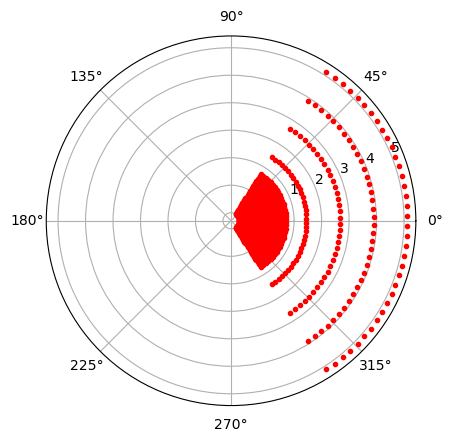

In [29]:
plt.polar(x_train_cyl[:,1], x_train_cyl[:,0], '.r', linewidth=2)
plt.show()

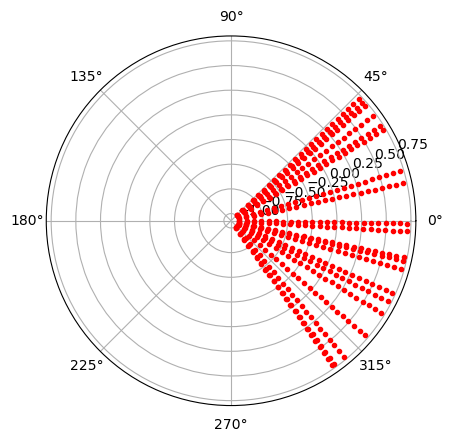

In [30]:
plt.polar(x_test_cyl[:,1], x_test_cyl[:,0], '.r', linewidth=2)
plt.show()

In [31]:
theta = 2.*(np.random.rand(36)-0.5)*np.pi
print(theta)
sig = FE.sp_cart(np.array([np.ones(36)*np.sqrt(3/2), theta]).T)
print(sig)
offs = 0.01
x = offs*sig
print(x)

[-2.67761641  1.91819144  1.02666063  0.60683429 -1.90415627  0.50894382
 -1.41936918 -0.61396415  0.6437193   1.61154495 -2.11779794  3.06965447
  0.64614103  1.01969786  1.79471791 -0.78757972 -0.82410537 -0.44136781
 -2.31876084  0.79559239  0.99378771 -3.13778832  0.6711152  -2.94431218
 -2.05281697 -2.81316181 -1.41864054  1.91930434 -3.01984661  1.46769134
  1.24789919  1.73866043  0.31864722 -1.98645712 -3.12485809 -0.11246808]
[[-0.7301767   0.04865275  0.68152395]
 [-0.27797601  0.80385416 -0.52587815]
 [ 0.42268297  0.39364143 -0.8163244 ]
 [ 0.67071719  0.06788307 -0.73860026]
 [-0.26717388 -0.53459237  0.80176625]
 [ 0.7130135  -0.01196529 -0.7010482 ]
 [ 0.12316778 -0.76059911  0.63743133]
 [ 0.66738034 -0.74106298  0.07368264]
 [ 0.65309036  0.09784231 -0.75093266]
 [-0.03326191  0.72315076 -0.68988885]
 [-0.42468329 -0.39158971  0.816273  ]
 [-0.81438476  0.4580165   0.35636827]
 [ 0.6519017   0.09980511 -0.7517068 ]
 [ 0.4275367   0.38865117 -0.81618787]
 [-0.18130715  

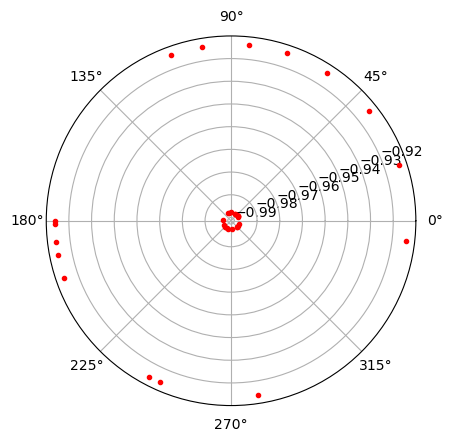

In [32]:
plt.polar(theta, x_test_cyl[:36,0], '.r', linewidth=2)
plt.show()

In [33]:
indr = np.nonzero(x_train_cyl[:,1]>1.-0.1)
indl = np.nonzero(x_train_cyl[:,1]<0.1-1.)
Xr = x_train_cyl[indr]
'''print(Xr)
plt.polar(Xr[:,1], Xr[:,0], '.r', linewidth=2)
#plt.show()'''
Xl = x_train_cyl[indl]
'''print(Xl)
plt.polar(Xl[:,1], Xl[:,0], '.r', linewidth=2)
plt.show()'''
Xr[:,1] -= 2.  # shift angle theta
Xl[:,1] += 2.
Xh = np.append(Xr, Xl, axis=0)
yh = np.append(y_train[indr], y_train[indl], axis=0)
x_train_cyl = np.append(x_train_cyl, Xh, axis=0)
y_train = np.append(y_train, yh, axis=0)

In [34]:
x_train_cyl.shape

(1120, 2)

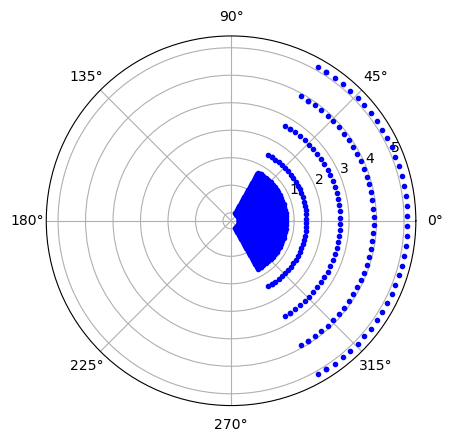

In [35]:
plt.polar(x_train_cyl[:,1], x_train_cyl[:,0], '.b', linewidth=2)
plt.show()

In [36]:
log_reg3 = LogisticRegression()
log_reg3.fit(x_train_cyl, y_train)

LogisticRegression()

In [37]:
y_pred6 = log_reg3.predict(x_test_cyl)

In [38]:
print(classification_report(y_test, y_pred6))

              precision    recall  f1-score   support

        -1.0       0.98      0.97      0.98       279
         1.0       0.97      0.98      0.97       201

    accuracy                           0.97       480
   macro avg       0.97      0.98      0.97       480
weighted avg       0.98      0.97      0.98       480



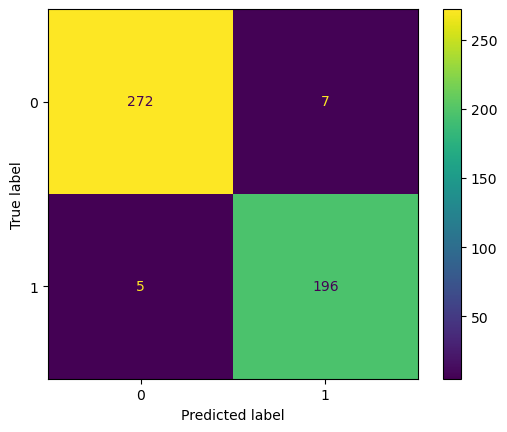

In [39]:
cm1 = confusion_matrix(y_test, y_pred6)
disp6 = ConfusionMatrixDisplay(cm1)
disp6.plot()
plt.show()

In [40]:
y_pred7 = log_reg3.predict(x_train_cyl)

In [41]:
print(classification_report(y_train, y_pred7))

              precision    recall  f1-score   support

        -1.0       0.97      0.98      0.97       551
         1.0       0.98      0.97      0.97       569

    accuracy                           0.97      1120
   macro avg       0.97      0.97      0.97      1120
weighted avg       0.97      0.97      0.97      1120



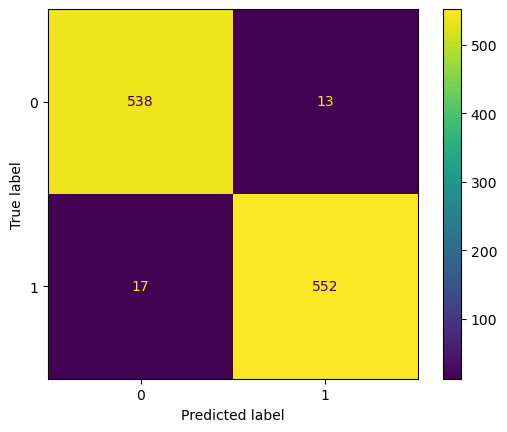

In [42]:
cm2 = confusion_matrix(y_train, y_pred7)
disp7 = ConfusionMatrixDisplay(cm2)
disp7.plot()
plt.show()

### Now we try KNN

In [43]:
x_train_cyl[:5,:]

array([[-0.98775255, -1.        ],
       [-0.98775255, -0.94285714],
       [-0.98775255, -0.88571429],
       [-0.98775255, -0.82857143],
       [-0.98775255, -0.77142857]])

With feature scaling

In [44]:
from sklearn.preprocessing import StandardScaler 
scaler = StandardScaler()

In [45]:
x_train_cyl = scaler.fit_transform(x_train_cyl)
x_test_cyl = scaler.transform(x_test_cyl)

In [46]:
x_train_cyl[:5,:]

array([[-0.96527975, -1.53751492],
       [-0.96527975, -1.44965693],
       [-0.96527975, -1.36179893],
       [-0.96527975, -1.27394094],
       [-0.96527975, -1.18608294]])

In [47]:
from sklearn.neighbors import KNeighborsClassifier

In [48]:
knn = KNeighborsClassifier(n_neighbors = 5, p=2)
knn.fit(x_train_cyl, y_train)
print(knn)

KNeighborsClassifier()


In [49]:
y_predknn = knn.predict(x_test_cyl)

In [50]:
print(classification_report(y_test, y_predknn))

              precision    recall  f1-score   support

        -1.0       0.99      1.00      0.99       279
         1.0       0.99      0.99      0.99       201

    accuracy                           0.99       480
   macro avg       0.99      0.99      0.99       480
weighted avg       0.99      0.99      0.99       480



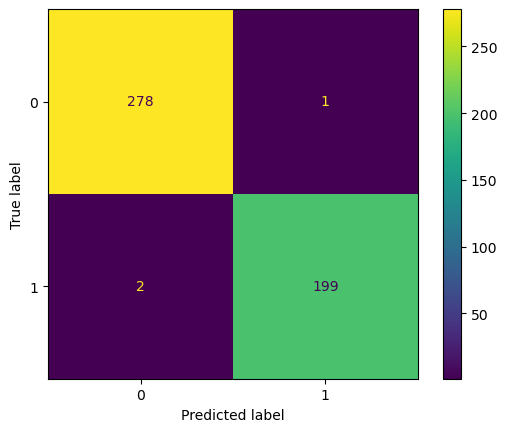

In [51]:
cm3 = confusion_matrix(y_test, y_predknn)
dispknn = ConfusionMatrixDisplay(cm3)
dispknn.plot()
plt.show()

In [52]:
from sklearn.metrics import accuracy_score

In [53]:
print(f"KNN training Accuracy: {accuracy_score(y_train, knn.predict(x_train_cyl))}")
print(f"KNN test Accuracy: {accuracy_score(y_test, y_predknn)}")

KNN training Accuracy: 0.9964285714285714
KNN test Accuracy: 0.99375


### Naive Bayes implementation

In [54]:
from sklearn.naive_bayes import GaussianNB 

Gnb = GaussianNB()
Gnb.fit(x_train_cyl, y_train)

GaussianNB()

In [55]:
y_predNB = Gnb.predict(x_test_cyl)

In [56]:
print(classification_report(y_test, y_predNB))

              precision    recall  f1-score   support

        -1.0       0.93      1.00      0.96       279
         1.0       1.00      0.90      0.94       201

    accuracy                           0.96       480
   macro avg       0.97      0.95      0.95       480
weighted avg       0.96      0.96      0.96       480



In [57]:
print(f"Naive Bayes training Accuracy: {accuracy_score(y_train, Gnb.predict(x_train_cyl))}")
print(f"Naive Bayes test Accuracy: {accuracy_score(y_test, y_predNB)}")

Naive Bayes training Accuracy: 0.95625
Naive Bayes test Accuracy: 0.95625


### We try DT

In [58]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()
dt.fit(x_train_cyl, y_train)

DecisionTreeClassifier()

In [59]:
y_predDT = dt.predict(x_test_cyl)

In [60]:
print(classification_report(y_test, y_predDT))

              precision    recall  f1-score   support

        -1.0       1.00      1.00      1.00       279
         1.0       1.00      1.00      1.00       201

    accuracy                           1.00       480
   macro avg       1.00      1.00      1.00       480
weighted avg       1.00      1.00      1.00       480



In [61]:
print(f"Decision Tree training Accuracy: {accuracy_score(y_train, dt.predict(x_train_cyl))}")
print(f"Decision Tree test Accuracy: {accuracy_score(y_test, y_predDT)}")

Decision Tree training Accuracy: 1.0
Decision Tree test Accuracy: 0.9958333333333333


In [62]:
from sklearn.tree import export_text

tree_rules = export_text(dt, feature_names=['J2_eq', 'Theta'])
print(tree_rules)

|--- J2_eq <= -0.25
|   |--- J2_eq <= -0.30
|   |   |--- J2_eq <= -0.35
|   |   |   |--- class: -1.0
|   |   |--- J2_eq >  -0.35
|   |   |   |--- Theta <= -1.14
|   |   |   |   |--- Theta <= -1.23
|   |   |   |   |   |--- class: -1.0
|   |   |   |   |--- Theta >  -1.23
|   |   |   |   |   |--- class: 1.0
|   |   |   |--- Theta >  -1.14
|   |   |   |   |--- Theta <= 0.35
|   |   |   |   |   |--- class: -1.0
|   |   |   |   |--- Theta >  0.35
|   |   |   |   |   |--- Theta <= 0.44
|   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |--- Theta >  0.44
|   |   |   |   |   |   |--- class: -1.0
|   |--- J2_eq >  -0.30
|   |   |--- Theta <= 0.70
|   |   |   |--- Theta <= 0.00
|   |   |   |   |--- Theta <= -0.79
|   |   |   |   |   |--- Theta <= -1.49
|   |   |   |   |   |   |--- class: -1.0
|   |   |   |   |   |--- Theta >  -1.49
|   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |--- Theta >  -0.79
|   |   |   |   |   |--- class: -1.0
|   |   |   |--- Theta >  0.00
|   |   |   |

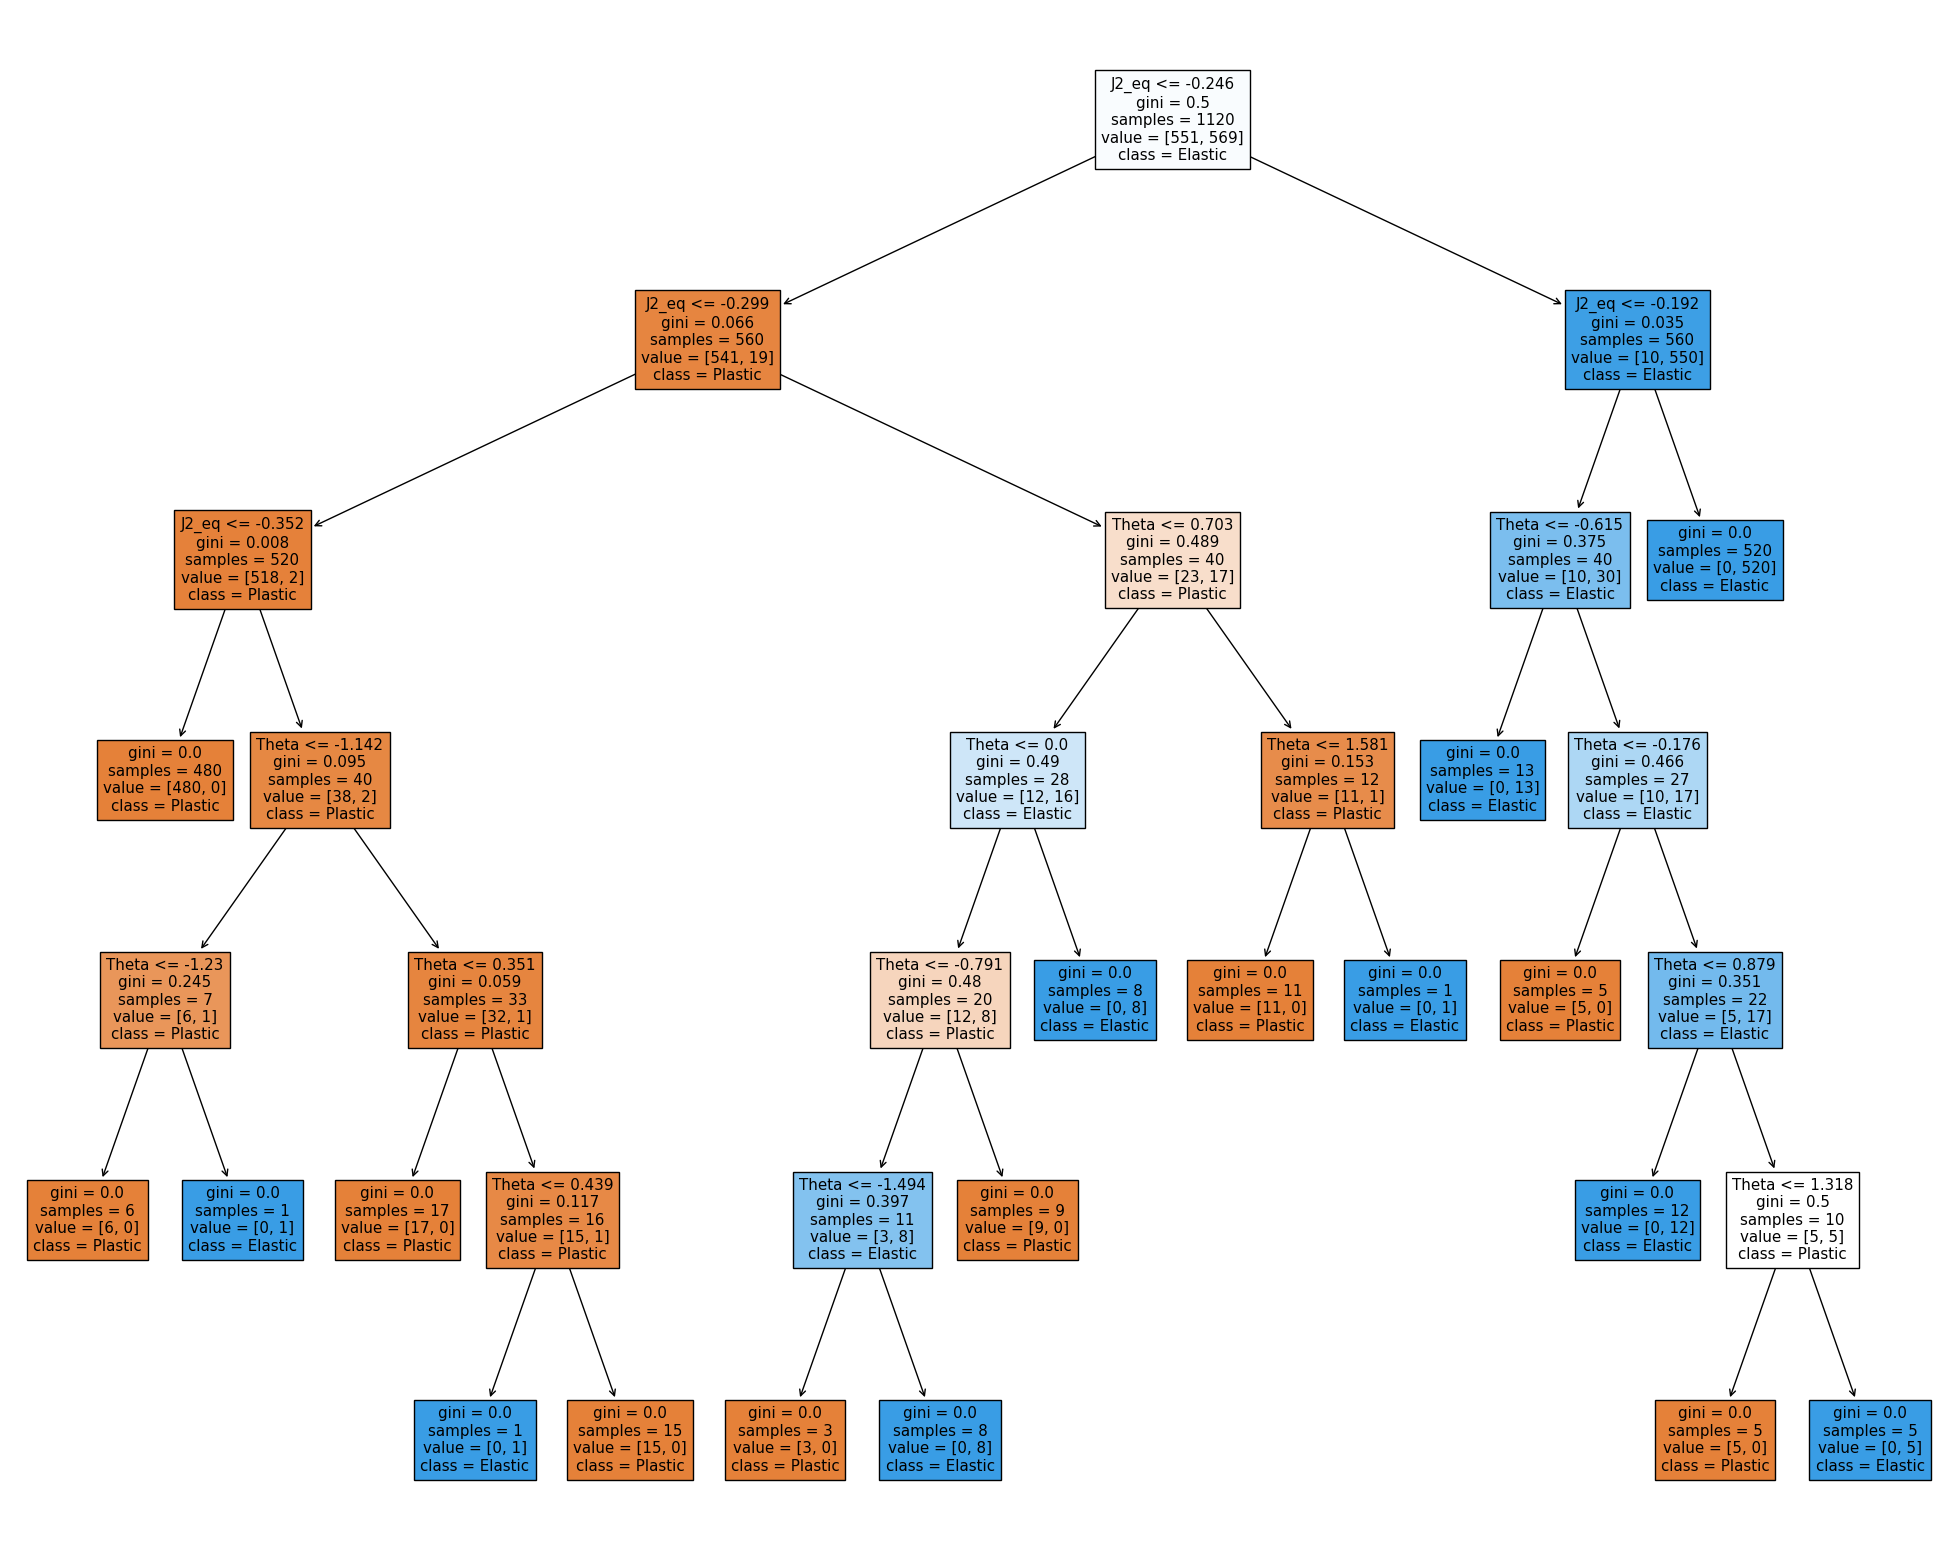

In [63]:
from sklearn import tree

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(dt, 
                   feature_names=['J2_eq', 'Theta'],  
                   class_names=['Plastic', 'Elastic'],
                   filled=True)
fig.savefig("decistion_tree.png")

#### DT piecewise function, will write later


### We try GPC

In [64]:
from sklearn.gaussian_process.kernels import RBF

kernel = 16.0 * RBF(0.5)

In [65]:
from sklearn.gaussian_process import GaussianProcessClassifier

gpc = GaussianProcessClassifier(kernel=kernel, optimizer=None)
gpc.fit(x_train_cyl, y_train)

GaussianProcessClassifier(kernel=4**2 * RBF(length_scale=0.5), optimizer=None)

In [66]:
y_predgpc = gpc.predict(x_test_cyl)

In [67]:
print(classification_report(y_test, y_predgpc))

              precision    recall  f1-score   support

        -1.0       1.00      1.00      1.00       279
         1.0       1.00      1.00      1.00       201

    accuracy                           1.00       480
   macro avg       1.00      1.00      1.00       480
weighted avg       1.00      1.00      1.00       480



In [68]:
print(f"GPC training Accuracy: {accuracy_score(y_train, gpc.predict(x_train_cyl))}")
print(f"GPC test Accuracy: {accuracy_score(y_test, y_predgpc)}")

GPC training Accuracy: 0.9982142857142857
GPC test Accuracy: 0.9979166666666667


#### Result visualization

For training data 

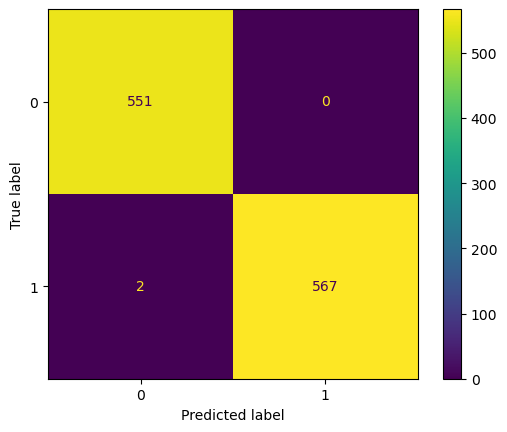

In [69]:
cm_gpc = confusion_matrix(y_train, gpc.predict(x_train_cyl))
disp_gpc = ConfusionMatrixDisplay(cm_gpc)
disp_gpc.plot()
plt.show()

For test data

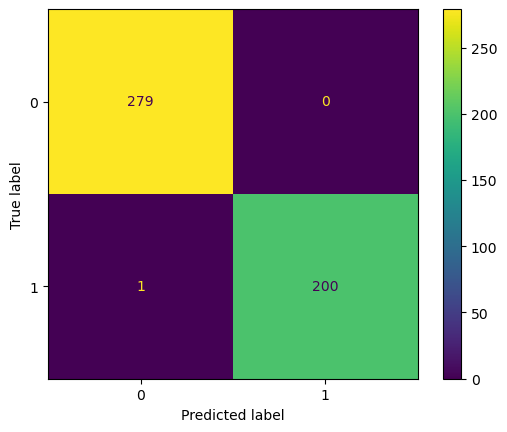

In [70]:
cm_gpc_test = confusion_matrix(y_test, y_predgpc)
disp_gpctest = ConfusionMatrixDisplay(cm_gpc_test)
disp_gpctest.plot()
plt.show()

### GPC funtion with Uncertainty

In [71]:
y_probagpc = gpc.predict_proba(x_test_cyl)
print(y_probagpc)
'''y_sigmagpc = np.zeros_like(y_probagpc)
for i in y_probagpc:
    y_sigmagpc[i]=1-y_probagpc[i]
y_sigmagpc'''

[[9.86759500e-01 1.32405003e-02]
 [9.89031653e-01 1.09683471e-02]
 [9.85471137e-01 1.45288634e-02]
 [9.87040544e-01 1.29594562e-02]
 [9.87068952e-01 1.29310479e-02]
 [9.90012031e-01 9.98796861e-03]
 [9.84292795e-01 1.57072046e-02]
 [9.90117674e-01 9.88232592e-03]
 [9.87444350e-01 1.25556499e-02]
 [9.87374634e-01 1.26253665e-02]
 [9.89868114e-01 1.01318859e-02]
 [9.82116071e-01 1.78839289e-02]
 [9.88592465e-01 1.14075349e-02]
 [9.88582357e-01 1.14176430e-02]
 [9.89714407e-01 1.02855932e-02]
 [9.81314110e-01 1.86858896e-02]
 [9.84107096e-01 1.58929042e-02]
 [9.88554778e-01 1.14452218e-02]
 [9.88562316e-01 1.14376844e-02]
 [9.87839253e-01 1.21607473e-02]
 [9.92763502e-01 7.23649780e-03]
 [9.94289022e-01 5.71097765e-03]
 [9.91682564e-01 8.31743577e-03]
 [9.92819257e-01 7.18074266e-03]
 [9.92667849e-01 7.33215119e-03]
 [9.94978434e-01 5.02156554e-03]
 [9.90857191e-01 9.14280867e-03]
 [9.95034590e-01 4.96541043e-03]
 [9.93202604e-01 6.79739620e-03]
 [9.93221386e-01 6.77861429e-03]
 [9.948517

'y_sigmagpc = np.zeros_like(y_probagpc)\nfor i in y_probagpc:\n    y_sigmagpc[i]=1-y_probagpc[i]\ny_sigmagpc'

In [72]:
y_hat_mean = np.mean(y_probagpc)
print(y_hat_mean)

0.5


In [73]:
y_hat_std = np.std(y_probagpc)
print(y_hat_std)

0.468578956705773
